<a href="https://colab.research.google.com/github/arthurziegler/ner-using-bert/blob/main/BERT_Experiment/bert_ner_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First test of the BERT model for NER
Using [an implementation by Tobias Sterbak](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/) as a base for the tests of the application of bert in this problem.

In [3]:
#!pip install transformers

In [201]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os.path

torch.__version__

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100

# Get ACERPI dataset

In [5]:
# #import tokenizer from nltk that is able to separate text into sentences and tokens.
# from nltk import tokenize, download
# download('punkt')

In [6]:
#annotated_data = pd.read_json("acerpi_dataset/train/annotated/new_file????", lines=True)

## Extracting SpaCy anottations
The first thing we'll do is to extract a list of labeled tokens. When importing from the spacy anotattion, the labels are not formatted by token, so we will need to go through the *spans* columns and the *tokens* columns to change the labelling from by document to be by token.

In [7]:
# entity_id = 0

# #Loop through each document
# for index, document in annotated_data.iterrows():
#     entity_tokens = {}

#     #In each entity on the 'spans' column we populate a dictionary with the id of the tokens and the entity they belong to
#     for entity in document['spans']:
#         for token_id in range(entity['token_start'], entity['token_end'] + 1, 1):
#             entity_tokens[token_id] = entity_id
#         entity_id += 1

#     #For each token in the 'tokens' column we give them the PER tag if they belong to an entity and tag the ID of the entity they belong to. We also tag the document ID.    
#     for token in document['tokens']:
#         if token['id'] in entity_tokens:
#             token['tag'] = 'PER'
#             token['entity_id'] = entity_tokens[token['id']]
#         else:
#             token['tag'] = 'O'

#         token['document'] = index

# print(entity_tokens)

In [8]:
# annotated_data.head(2)

## Flatten array of lists
The 'tokens' columns is currently in a format where each row contain a list of dictionaries. Since we want a single list of token we need to flatten it so that we only have a single list of dictionaries that contains the tokens from every single document of the dataset. We will not lose the document information since we added it as a key-value pair of the dictionary before.

In [9]:
# tagged_tokens = annotated_data['tokens'].to_numpy()

# token_dict_list = []
# for index, dict_list in enumerate(tagged_tokens):
#     token_dict_list += dict_list

In [10]:
# print(type(tagged_tokens))
# print(type(token_dict_list))
# token_dict_list[0:5]

Now we transform the list of dictionaries into a dataframe and each column will be a single anotated token. We only care about the tokens that were anotatted as 'PER' by the SpaCy library since we still want to clean the rest of the document and the other tokens might change.

In [11]:
# pd.options.display.max_rows = None
# token_df = pd.DataFrame(token_dict_list)

# token_df = token_df[token_df['tag'] == 'PER'].drop(columns = ['start', 'end', 'id', 'document'])
# token_df.head()

In [12]:
# # There are two instances of tokens with \n and a whitespace, we want to remove those because they won't be present in our cleaned text later on.
# print(token_df.shape)
# token_df = token_df[token_df['text'].str.fullmatch(r'([A-zÀ-ÿ]+)')]
# print(token_df.shape)

In [13]:
# # Find repeated entities in token_df and remove them to have a more compact dataframe
# token_groups = token_df.groupby(by='entity_id')
# n_of_entities = int(token_df['entity_id'].max())
# duplicate_entities = []
# for entity_id in range(n_of_entities+1):
#     named_entity = token_groups.get_group(entity_id).reset_index(drop=True)[['text', 'tag']]
#     for cmp_index in range(entity_id + 1, n_of_entities+1):
#         other_entity = token_groups.get_group(cmp_index).reset_index(drop=True)[['text', 'tag']]
#         if named_entity.equals(other_entity):
#             duplicate_entities += (list(token_groups.get_group(cmp_index).index.values))

# #print(duplicate_entities)
# token_df = token_df.drop(index=duplicate_entities)

In [14]:
# print(token_df.shape)
# token_df.head(10)

## Clean the text
The document text contains several things like repeated spaces, new line character and wrong punctuation that could break our sentence split afterwards

In [15]:
# def clear_text(text_input_series):
#     clean_text = text_input_series.copy()
#     #print("Document BEFORE pre-processing" + '\n--------------------------------\n' + clean_text[1])
#     # #Remove \n character and repeated whitespaces
#     clean_text = clean_text.replace(r'(nº\.) ?','nº ', regex=True)
#     clean_text = clean_text.replace(r'\n',' ', regex=True)
#     clean_text = clean_text.replace(r'[ ]+', ' ', regex = True)
#     #print("Document AFTER pre-processing" + '\n--------------------------------\n' + clean_text[1])
#     return clean_text
 
#clean_text = clear_text(annotated_data['text'])

In [16]:
# type(clean_text)

In [17]:
# # def split_text_sentences(text_input_series):
# #     # #Split documents into phrases
# #     sentence_df = text_input_series.apply(lambda row: tokenize.sent_tokenize(row, language='portuguese'))

# #     # #Turn series of list of phrases into series of phrases. Index will indicate which document it belongs to for now.
# #     sentence_df = sentence_df.explode()
# #     sentence_df = pd.DataFrame(sentence_df)
    
# #     # Put sentece_df index as a column and the sentence id as another column
# #     sentence_df = sentence_df.reset_index()
# #     sentence_df['SentenceID'] = sentence_df.index
# #     sentence_df.columns = ['document', 'sentence', 'sentence_id']
# #     sentence_df.head()

# sentence_df = data_cleaning.split_text_sentences(input_text_series????)

In [18]:
# # Add a 'tokens' column tokenzing the 'sentence' column
# sentence_df['tokens'] = sentence_df.apply(lambda row: tokenize.word_tokenize(row['sentence'], language='portuguese'), axis=1)
# sentence_df.head()

In [19]:
# # Format the final dataframe where each row will be a token and the columns will be 'Sentence', 'Word' and 'Tag'.
# token_input_df = sentence_df.explode('tokens').drop(columns=['document', 'sentence']).reset_index(drop=True)
# token_input_df.head()

In [20]:
# token_df.head()

In [21]:
# # Anotate token_input_df based on the labels in the token_df dataframe we got from spacy.
# def labeled_entities(tokens, labeled_entities):
#     tokens['label'] = 'O'
#     for entity in range(int(labeled_entities['entity_id'].max())):
#         matched_tokens = []
#         entity = list(labeled_entities['text'][labeled_entities['entity_id'] == entity])#.iterrows()
#         if entity:
#             #print('\nEntitiy Token List:\n', entity)
#             #print(len(entity))
#             first_tokens = tokens[tokens['tokens'] == entity[0]]
#             #print(first_tokens)
#             first_index_list = first_tokens.index.values
#             #print(first_index_list)
#             #print('\nPossible entity matches:')
#             for index in first_index_list:
#                 #print(list(tokens['tokens'].iloc[index:index + len(entity)]))
#                 found_token_list = list(tokens['tokens'].iloc[index:index + len(entity)])
#                 #print(found_token_list == entity)
#                 if found_token_list == entity:
#                     tokens['label'].iloc[index:index + len(entity)] = 'PER'
#     return tokens

In [22]:
# token_final = labeled_entities(token_input_df, token_df)

In [23]:
# token_final.columns = ['Sentence #', 'Word', 'Tag']
# token_final[token_final['Tag'] == 'PER'].head()

In [24]:
# def apply_iob_format(token_df):
#     for token_idx in range(token_df.shape[0]):
#         if token_df['Tag'].iloc[token_idx] == 'PER':
#             if token_df['Tag'].iloc[token_idx-1] == 'O':
#                 token_df['Tag'].iloc[token_idx] = 'B-per'
#             else:
#                 token_df['Tag'].iloc[token_idx] = 'I-per'
#     return token_df

In [25]:
# token_final = apply_iob_format(token_final)

In [26]:
# token_final['Word'] = token_final.apply(lambda row: row['Word'].capitalize() if row['Tag'] != 'O' else row['Word'], axis=1)#[row['Tag'] != 'O'].str.capitalize())

In [27]:
# token_final[token_final['Tag'] != 'O'].head()

In [202]:
train_file_path = "acerpi_dataset/train/annotated/"
test_file_path = "acerpi_dataset/test/annotated/"

train_data = pd.read_csv(train_file_path + 'acerpi_ner_ufrgs_train_data')

In [205]:
train_data.head()

,Sentence #,Word,Tag
0,0,Documento,O
1,0,gerado,O
2,0,sob,O
3,0,autenticação,O
4,0,Nº,O


In [206]:
train_data.shape

(63835, 3)

In [207]:
print(train_data['Sentence #'][train_data['Tag'] != 'O'].unique().shape)
print(train_data['Sentence #'].unique().shape)

(640,)
(1239,)


As we can see, our dataset has a lot of data from sentences that have no named entities. Using this sentences would mean training our model with data that doesn't contribute to our goal of classifing named entities, since they will only be an example of how to classify word that are not in one.

Because of this we will filter our dataset so that it only contains sentences which have at least on named entity in them. This will ensure that during training phase we are tuning the model to find the named entities inside sentences.

In [208]:
ner_sentences = train_data['Sentence #'][train_data['Tag'] != 'O'].unique()
train_data = train_data[train_data['Sentence #'].isin(ner_sentences)]

In [209]:
train_data.shape

(48604, 3)

# Bert Tokenize

In [149]:
class SentenceGetter(object):

    def __init__(self, data):
        print("a")
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           #s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        print("h")
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [210]:
getter = SentenceGetter(train_data)

a


In [211]:
getter.sentences[0][0:10]

[('1/1', 'O'),
 ('PORTARIA', 'O'),
 ('Nº', 'O'),
 ('6839', 'O'),
 ('de', 'O'),
 ('02/09/2016', 'O'),
 ('O', 'O'),
 ('VICE-REITOR', 'O'),
 (',', 'O'),
 ('NO', 'O')]

In [212]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0][0:10]

['1/1',
 'PORTARIA',
 'Nº',
 '6839',
 'de',
 '02/09/2016',
 'O',
 'VICE-REITOR',
 ',',
 'NO']

In [153]:
sentences[2][0:10]

['1/1',
 'PORTARIA',
 'Nº',
 '6495',
 'de',
 '20/07/2017',
 'A',
 'VICE-REITORA',
 ',',
 'NO']

In [213]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [214]:
tag_values = list(set(train_data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [215]:
print(tag_values)
print(tag2idx)

['O', 'B-per', 'I-per', 'PAD']
{'O': 0, 'B-per': 1, 'I-per': 2, 'PAD': 3}


In [216]:
MAX_LEN = 75
bs = 32

In [217]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
device

device(type='cuda')

In [218]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070 Ti'

In [219]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [220]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [162]:
print(len(sentences))

640


In [221]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [222]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [223]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [229]:
print(tokenized_texts[600])
print(input_ids[600])


['Ma', '##ur', '##í', '##cio', 'V', '##i', '##é', '##gas', 'Da', 'Silva', 'P', '##r', '##ó', '-', 'Re', '##itor', 'de', 'G', '##est', '##ão', 'de', 'P', '##ess', '##oa', '##s']
[ 7085  2149  6212  8174   159  1182  2744 11305 10136 11211   153  1197
  7774   118 11336 15419  1260   144  2556  9290  1260   153  5800 12985
  1116     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [230]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [231]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [232]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [241]:
tr_txt, val_txt, _, _ = train_test_split(tokenized_texts, input_ids,
                                             random_state=2018, test_size=0.1)

In [243]:
val_tags[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [244]:
val_inputs[0]

array([  122,   120,   122,   153,  9565,  9159, 20595,  1592,   151,
       28174,  9377, 23124,  1260,  1476,   120,  1367,   120,  1446,
         152, 11629, 28191,   118,   155, 27514, 18082,  2069, 18581,
         100, 18581,   153,  9919, 23161, 10719,   141,  1592,  7414,
       26140,  8900,  9949, 14569,  2036,   143, 10069,  9637, 12507,
         141,  2346,   155, 19368,   144,  9664, 16769,  2036,   141,
        2346,   156,  2591,  2162,   117,  1185,  1366,  1186,  1260,
       28117,  2225,  1120,  2047,  7925,  1182, 28201, 28207,  1279,
       15027,   181,  4638])

In [245]:
val_txt[0]

['1',
 '/',
 '1',
 'P',
 '##OR',
 '##TA',
 '##RI',
 '##A',
 'N',
 '##º',
 '104',
 '##34',
 'de',
 '30',
 '/',
 '12',
 '/',
 '2016',
 'O',
 'PR',
 '##Ó',
 '-',
 'R',
 '##EI',
 '##TO',
 '##R',
 'DE',
 '[UNK]',
 'DE',
 'P',
 '##ES',
 '##SO',
 '##AS',
 'D',
 '##A',
 'UN',
 '##IVE',
 '##RS',
 '##ID',
 '##AD',
 '##E',
 'F',
 '##ED',
 '##ER',
 '##AL',
 'D',
 '##O',
 'R',
 '##IO',
 'G',
 '##RA',
 '##ND',
 '##E',
 'D',
 '##O',
 'S',
 '##U',
 '##L',
 ',',
 'no',
 'us',
 '##o',
 'de',
 'su',
 '##as',
 'at',
 '##ri',
 '##bu',
 '##i',
 '##ç',
 '##õ',
 '##es',
 'que',
 'l',
 '##he',
 'for',
 '##am',
 'con',
 '##fer',
 '##idas',
 'p',
 '##ela',
 'Port',
 '##aria',
 'n',
 '##º',
 '76',
 '##8',
 '##4',
 ',',
 'de',
 '03',
 'de',
 'out',
 '##ub',
 '##ro',
 'de',
 '2016',
 ',',
 'do',
 'Ma',
 '##gn',
 '##í',
 '##fic',
 '##o',
 'Re',
 '##itor',
 ',',
 'e',
 'conform',
 '##e',
 'a',
 'Sol',
 '##icit',
 '##a',
 '##ção',
 'de',
 'F',
 '##é',
 '##ria',
 '##s',
 'n',
 '##°',
 '##26',
 '##4',
 '##9',
 '##7',
 '

In [172]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long)
val_tags = torch.tensor(val_tags, dtype=torch.long)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [173]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [174]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.11.3'

In [175]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [176]:
#torch.cuda.empty_cache()
model.cuda();

In [177]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [178]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [179]:
!pip install seqeval==0.0.12
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score

In [180]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))

    # Loop through the list of predicted sentences and their true labels in the validation set
    pred_tags = []
    valid_tags = []
    for prediction, labels in zip(predictions, true_labels):
        # For each token in the sentence we verify if the true value is a padding, and if it isn't, then we add it to the list of predicted tags.
        # This is done because we don't care about how paddings are predicted, since they're not part of the original data.
        for p_i, l_i, in zip(prediction, labels):
            if tag_values[l_i] != 'PAD':
                pred_tags.append(tag_values[p_i])
                valid_tags.append(tag_values[l_i])

    # Calculate the metrics for this epoch using our predictions and our true values for each token.
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation Precision: {}".format(precision_score(pred_tags, valid_tags)))
    print("Validation Recall: {}".format(recall_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.2558127416090833


Epoch:  33%|███▎      | 1/3 [00:06<00:12,  6.01s/it]

Validation loss: 0.016292601823806763
Validation Accuracy: 0.9966153846153846
Validation Precision: 0.8351648351648352
Validation Recall: 0.926829268292683
Validation F1-Score: 0.8786127167630058

Average train loss: 0.012545691169280972
Validation loss: 0.0032407520338892937
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0


Epoch:  67%|██████▋   | 2/3 [00:11<00:05,  5.99s/it]

Validation F1-Score: 1.0

Average train loss: 0.006678424012433324


Epoch: 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]

Validation loss: 0.0015217746258713305
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1-Score: 1.0



In [181]:
#outputs['logits']

In [182]:
pred_df = pd.DataFrame()

In [183]:
pred_df['predictions'] = pred_tags
pred_df['predictions2'] = valid_tags


In [185]:
pred_df[pred_df['predictions'] != 'O'].head(100)

,predictions,predictions2
150,B-per,B-per
151,B-per,B-per
152,B-per,B-per
153,I-per,I-per
154,I-per,I-per
155,I-per,I-per
163,B-per,B-per
164,I-per,I-per
165,I-per,I-per
166,I-per,I-per


In [186]:
print(len(sentences))

640


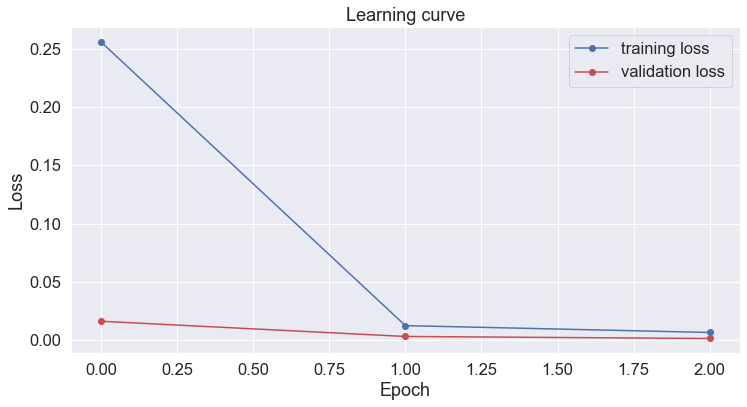

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [188]:
test_sentence = """
Documento gerado sob autenticação Nº QON.500.984.BHA, disponível no endereço http://www.ufrgs.br/autenticacao
1/1
PORTARIA Nº             1184                  de  18/02/2016
O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no
uso de suas atribuições que lhe foram conferidas pela Portaria nº.5469, de 04 de outubro de 2012, do
Magnífico Reitor, e conforme o Laudo Médico n°37308,
RESOLVE: José Da Silva
Designar, temporariamente, nos termos\ da Lei nº. 8.112, de 11 de dezembro de 1990, com redação
dada pela Lei nº.9.527, de 10 de dezembro de 1997, a ocupante do cargo de PORTEIRO, do Quadro de
Pessoal  desta  Universidade, 
"""

In [189]:
#sentence_df['sentence'][21]

In [190]:
#test_sentence = sentence_df['sentence'][1]

In [191]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [192]:
type(tokenized_sentence)

list

In [193]:
input_ids

tensor([[  101, 11387, 15447, 10153,   176,  5970,  2572, 20295, 12686,  5208,
         11761, 18052,   151, 28174,   154, 11414,   119,  2260,   119,  5103,
          1527,   119,   139, 11612,   117,  4267, 20080,  1320,  6212, 12559,
          1185,  1322,  9014, 28201,  1186,  8413,   131,   120,   120,  7001,
           119,   190,  2087, 10805,  1116,   119,  9304,   120, 12686,  5208,
         11761,  2599,  1186,   122,   120,   122,   153,  9565,  9159, 20595,
          1592,   151, 28174, 13176,  1527,  1260,  1407,   120,  5507,   120,
          1446,   152, 11629, 28191,   118,   155, 27514, 18082,  2069, 18581,
           100, 18581,   153,  9919, 23161, 10719,   141,  1592,  7414, 26140,
          8900,  9949, 14569,  2036,   143, 10069,  9637, 12507,   141,  2346,
           155, 19368,   144,  9664, 16769,  2036,   141,  2346,   156,  2591,
          2162,   117,  1185,  1366,  1186,  1260, 28117,  2225,  1120,  2047,
          7925,  1182, 28201, 28207,  1279, 15027,  

In [194]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [195]:
# join bpe split tokens

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    #print('Token: ', token, ' Label: ', label)
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [196]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	Documento
O	gerado
O	sob
O	autenticação
O	Nº
O	QON
O	.
O	500
O	.
O	984
O	.
O	BHA
O	,
O	disponível
O	no
O	endereço
O	http
O	:
O	/
O	/
O	www
O	.
O	ufrgs
O	.
O	br
O	/
O	autenticacao
O	1
O	/
O	1
O	PORTARIA
O	Nº
O	1184
O	de
O	18
O	/
O	02
O	/
O	2016
O	O
O	PRÓ
O	-
O	REITOR
O	DE
O	[UNK]
O	DE
O	PESSOAS
O	DA
O	UNIVERSIDADE
O	FEDERAL
O	DO
O	RIO
O	GRANDE
O	DO
O	SUL
O	,
O	no
O	uso
O	de
O	suas
O	atribuições
O	que
O	lhe
O	foram
O	conferidas
O	pela
O	Portaria
O	nº
O	.
O	5469
O	,
O	de
O	04
O	de
O	outubro
O	de
O	2012
O	,
O	do
O	Magnífico
O	Reitor
O	,
O	e
O	conforme
O	o
O	Laudo
O	Médico
O	n°37308
O	,
O	RESOLVE
O	:
O	José
O	Da
O	Silva
O	Designar
O	,
O	temporariamente
O	,
O	nos
O	termos
O	\
O	da
O	Lei
O	nº
O	.
O	8
O	.
O	112
O	,
O	de
O	11
O	de
O	dezembro
O	de
O	1990
O	,
O	com
O	redação
O	dada
O	pela
O	Lei
O	nº
O	.
O	9
O	.
O	527
O	,
O	de
O	10
O	de
O	dezembro
O	de
O	1997
O	,
O	a
O	ocupante
O	do
O	cargo
O	de
O	PORTEIRO
O	,
O	do
O	Quadro
O	de
O	Pessoal
O	desta
O	Universidade
O	,
O	[SEP]
